In [7]:
import os, math, numpy as np
import pandas as pd
import copy
from collections import defaultdict

In [6]:
def get_distance(source: tuple, destination : tuple) -> float:
    return ((source[1] - destination[1]) ** 2 + (source[0] - destination[0]) ** 2)**0.5

In [65]:
### Calculate travel time between two points: origin and destination
def travel_time(origin_id,destination_id,meters_per_minute,locations):
    dist=np.sqrt((locations.at[destination_id,'x']-locations.at[origin_id,'x'])**2\
                +(locations.at[destination_id,'y']-locations.at[origin_id,'y'])**2)
    tt=np.ceil(dist/meters_per_minute)
    return tt

# Read in data instance
A folder of data instance has 5 files: (1) couriers.txt, (2) instance_characteristics.txt, (3) instance_parameters.txt, (4) orders.txt, (5) restaurants.txt

In [42]:
# Read instance information
def read_instance_information(instance_dir):
    orders=pd.read_table(os.path.join(instance_dir,'orders.txt'))
    restaurants=pd.read_table(os.path.join(instance_dir,'restaurants.txt'))
    couriers=pd.read_table(os.path.join(instance_dir,'couriers.txt'))
    instanceparams=pd.read_table(os.path.join(instance_dir,'instance_parameters.txt'))

    order_locations=pd.DataFrame(data=[orders.order,orders.x,orders.y]).transpose()
    order_locations.columns=['id','x','y']
    restaurant_locations=pd.DataFrame(data=[restaurants.restaurant,restaurants.x,restaurants.y]).transpose()
    restaurant_locations.columns=['id','x','y']
    courier_locations=pd.DataFrame(data=[couriers.courier,couriers.x,couriers.y]).transpose()
    courier_locations.columns=['id','x','y']
    locations=pd.concat([order_locations,restaurant_locations,courier_locations])
    locations.set_index('id',inplace=True)

    meters_per_minute=instanceparams.at[0,'meters_per_minute']
    pickup_service_minutes=instanceparams.at[0,'pickup service minutes']
    dropoff_service_minutes=instanceparams.at[0,'dropoff service minutes']
    target_click_to_door=instanceparams.at[0,'target click-to-door']
    pay_per_order=instanceparams.at[0,'pay per order']
    guaranteed_pay_per_hour=instanceparams.at[0,'guaranteed pay per hour']

    return orders,restaurants,couriers,instanceparams,locations, meters_per_minute, pickup_service_minutes, dropoff_service_minutes, \
            target_click_to_door, pay_per_order,\
            guaranteed_pay_per_hour

In [43]:
instance_dir = 'data/0o50t75s1p100'
orders,restaurants,couriers,instanceparams,locations, meters_per_minute, pickup_service_minutes, dropoff_service_minutes, \
            target_click_to_door, pay_per_order,\
            guaranteed_pay_per_hour=read_instance_information(instance_dir)

In [170]:
restaurants


,restaurant,x,y
0,r1,7818,3668
1,r2,8483,4501
2,r3,8320,4472
3,r4,7880,3494
4,r5,6899,3160
...,...,...,...
88,r89,8142,3753
89,r90,8515,5778
90,r91,8694,5518
91,r92,9344,5622


# Set hyper-parameters:
f∶ every f minutes solves a matching problem to prescribe the next pick-up and delivery assignment for each courier<br>
t : optimization time<br>
∆_(u): t+ ∆_(u ) is the assignment horizon<br>
∆_(1); ∆_(2): to determine Z_(t)<br>
beta: control the freshness in the construction of bundles
gamma: control the click to door time in the construction of bundles


In [10]:
# Accorting to default values in the paper
f = 5
delta_u = 10
# delta_1 = 10 (do not use delta_1)
# delta_2 = 10 (do not use delta_1)
# Not find in the paper
beta = 10 # should be tuned
gamma = 10 # should be tuned

# Procedure to initialize a solution

**Order Object**

In [67]:
class Order:
    def __init__(self, order_information : dict):

        self.id = order_information.get('order')
        self.destination = (order_information.get('x'), order_information.get('y'))
        self.placement_time = order_information.get('placement_time')
        self.restaurant_id = order_information.get('restaurant')
        self.ready_time = order_information.get('ready_time')
        
        # To be updated after assignment
        self.pickup_time = 0
        self.dropoff_time = 0
        self.courier_id = ""

**Route object**<br>
A route is a bundle,i.e: a list of ordered orders

In [78]:
class Route(object):
    def __init__(self,bundle : list, restaurant_id : str): 
        self.bundle = bundle 
        self.restaurant_id = restaurant_id
        
        # Hyperparameters
        self.beta = 5 
        self.gamma = 10
        
    def get_ready_time(self):
        ready_time = max([o.ready_time for o in self.bundle])
        return ready_time

    # calculate total travel time from 1st destination to the last destination of the route
    # do not include pickup service time and drop off service time
    def get_total_travel_time(self,meters_per_minute,locations):
        travel_points = [self.restaurant_id]+ [o.id for o in self.bundle]
        if len(travel_points) == 1:
            return 0
        else:
            total_travel_time = 0
            for i in range(len(travel_points)-1):
                total_travel_time += travel_time(travel_points[i], travel_points[i+1],meters_per_minute,locations)
            return total_travel_time

    def get_end_position(self,meters_per_minute,locations):
        return self.bundle[-1].id

    # calculate total service delay 
    # service delay = arrival_time at customer place - ready time (ignoring pickup service time and dropoff service time)
    def get_total_service_delay(self,meters_per_minute,locations):
        travel_points = [self.restaurant_id]+ [o.id for o in self.bundle]
        if len(travel_points) == 1:
            return 0
        else:
            total_service_delay = 0
            arrival_time_at_cp = self.get_ready_time()
            for i in range(len(travel_points)-1):
                arrival_time_at_cp += (travel_time(travel_points[i], travel_points[i+1],meters_per_minute,locations))
                total_service_delay += (arrival_time_at_cp - self.bundle[i].ready_time)
            return total_service_delay

    # calculate total_click_to_door 
    # click_to_door = arrival_time at customer place - placement time (ignoring pickup service time and dropoff service time)
    # the below function implement 
    def get_total_service_waiting(self,meters_per_minute,locations):
        travel_points = [self.restaurant_id]+[o.id for o in self.bundle]
        if len(travel_points) == 1:
            return 0
        else:
            total_service_waiting = 0
            arrival_time_at_cp = self.get_ready_time()
            for i in range(len(travel_points)-1):
                arrival_time_at_cp += (travel_time(travel_points[i], travel_points[i+1],meters_per_minute,locations))
                total_service_waiting += (arrival_time_at_cp - self.bundle[i].placement_time)
            return total_service_waiting

    # calculate route efficiency: travel time per order:
    def route_efficiency(self,meters_per_minute,locations):
        return len(self.bundle) / self.get_total_travel_time(meters_per_minute,locations)

    # calculate route cost
    def get_route_cost(self,meters_per_minute,locations):
        route_cost = self.get_total_travel_time(meters_per_minute,locations) + self.beta * self.get_total_service_delay(meters_per_minute,locations) + self.gamma * self.get_total_service_waiting(meters_per_minute,locations)
        return route_cost


**Assignment Object**

In [112]:
class Assignment():
    def __init__(self, assign_time : int , restaurant_id : str, courier: object, route : Route):
        self.assign_time = assign_time
        self.restaurant_id = restaurant_id  # each assignment of a bundle has only one corresponding restaurant
        self.pickup_time = 0
        self.courier = courier
        self.route = route
        self.isfinal_flag = 0 # indicate if the assignment is final (can not be updated)
        self.update_time = 0

    def update(self, new_assignment, meters_per_minute,locations):
        # update the new assignment into the old assignment
        # combine orders in the new assigment with orders in the old assignment
        for o in new_assignment.route.bundle:
            n = len(self.route.bundle)
            min_route_cost = float('inf')
            best_pos = 0
            for pos in range(n+1):
                self.route.bundle.insert(pos,o)
                route_cost = self.route.get_route_cost(meters_per_minute,locations)
                if route_cost < min_route_cost:
                    min_route_cost = route_cost
                    best_pos = pos
                self.route.bundle.pop(pos)
            self.route.bundle.insert(best_pos, o)
        # if the new assigment is final (isfinal_flage = 1), set isfinal_flag of the combination as 1
        if new_assignment.isfinal_flag == 1:
            self.isfinal_flag = 1
        else: # if the new assigment is not final (isfinal_flage = 0)
            # if there is an order that has been ready for x minutes, set assignment as final
            if not self.is_no_order_long_ready_time():
                self.isfinal_flag = 1
            else: # if there is no order that has been ready for x minutes, set assignment as tentative
                self.isfinal_flag = 0
        self.update_time +=1
        self.assign_time = new_assignment.assign_time

    def is_no_order_long_ready_time(self, x = 40) -> bool:
        for o in self.route.bundle:
            route_ready_time = self.route.bundle.get_ready_time()
            if route_ready_time - o.ready_time >= x:
                return False
        return True

**Courier Object**

In [18]:
class Courier(object):
    def __init__(self, courier_information : dict, ):
        self.id = courier_information.get('courier')
        self.x = courier_information.get('x')
        self.y = courier_information.get('y')
        self.on_time = courier_information.get('on_time')
        self.off_time = courier_information.get('off_time')

        # Sequence of moves of the courier
        # Update and derived along the way
        self.assignments = []                           # containing assigned assigments 
        self.next_available_time = self.on_time                 # when the courier is available for the next assignment (or the drop off time of the last order of the last assignment)
        self.position_after_last_assignment = self.id  # the position of the courier after completing the last assignment           

**DeliveryRouting Object**

In [184]:
class DeliveryRouting:
    def __init__(self, instance_dir : str):

        orders, restaurants, couriers, instanceparams, locations ,\
        self.meters_per_minute, self.pickup_service_minutes, self.dropoff_service_minutes, \
            self.target_click_to_door, self.pay_per_order,\
            self.guaranteed_pay_per_hour = read_instance_information(instance_dir)


        self.orders = [Order(order) for order in orders.to_dict(orient = 'records')]
        self.orders = sorted(self.orders, key = lambda x: x.id)

        self.restaurants = restaurants
        self.couriers = [Courier(courier) for courier in couriers.to_dict(orient = 'records')]
        self.unassigned_orders = self.copy(self.orders)
        
        self.orders_by_horizon_interval = defaultdict(list)
        self.locations = locations

        # Hyperparameters
        self.f = 5
        self.delta_u = 10


    def travel_time(self, origin_id,destination_id):
        dist=np.sqrt((self.locations.at[destination_id,'x']-self.locations.at[origin_id,'x'])**2\
                    +(self.locations.at[destination_id,'y']-self.locations.at[origin_id,'y'])**2)
        tt=np.ceil(dist/self.meters_per_minute)
        return tt

    def copy(self,x):
        return copy.deepcopy(x)

    def get_ready_orders(self) -> dict:
        '''
        This function return orders which have ready time fall into the corresponding horizon.
        This function should be run only once.
        '''
        # starting time of each interval
        t_list = [*range(0,24*60+1,self.f)]
        # get ready orders correspoding to each horizon interval
        for i in range(1,len(t_list)):
            for o in self.orders:
                if o.placement_time < t_list[i] and o.placement_time >= t_list[i-1] and o.ready_time < t_list[i]+self.delta_u:
                    self.orders_by_horizon_interval[t_list[i]].append(o)
                if o.placement_time < t_list[i] and o.placement_time >= t_list[i-1] and o.ready_time >= t_list[i]+self.delta_u:
                    self.orders_by_horizon_interval[t_list[i]+self.f*np.ceil((o.ready_time - (t_list[i]+self.delta_u))/self.f)].append(o)

    def get_ready_orders_at_t(self,t):
        return self.orders_by_horizon_interval[t]

    def get_idle_courier_at_t(self,t):
        idle_courier = []
        for c in self.couriers:
            if c.next_available_time < t+self.delta_u and c.next_available_time < c.off_time :
                idle_courier.append(c)
        return idle_courier

    def get_bundle_size(self, t) -> int :
        
        number_of_orders = len(self.get_ready_orders_at_t(t))
        number_of_couriers = len(self.get_idle_courier_at_t(t))
        if number_of_couriers == 0:
            bundle_size = 2 # default value of bundle size
        else:
            bundle_size = np.ceil(number_of_orders/number_of_couriers)
        return bundle_size

    # check if the courier can take a bundle. 
    def can_assign(self, t, courier, route : Route) -> bool:
        route_ready_time = route.get_ready_time()
        if route_ready_time < self.on_time:
            return False
        if route_ready_time> self.off_time:
            return False
        if len(courier.assignements) > 0:
            if courier.assignements[-1].isfinal_flag == 0:
                if courier.assignements[-1].restaurant_id != route.restaurant_id:
                    return False
        return True

    # assign a bundle to a courier
    def assign_bundle(self, t: int, courier: Courier, route: Route):
        # calculate courier's arrival time to the bundle's restaurant:
        arrival_time = courier.next_available_time +\
                        self.dropoff_service_minutes/2 +\
                         self.travel_time(courier.position_after_last_assignment,route.restaurant_id) +\
                          self.pickup_service_minutes/2
        route_ready_time = route.get_ready_time()
        ### Commitment strategy
        # If d can reach restaurant r before t + f and all orders in s are estimated to be ready by t + f,
        # make a final commitment of d to s: instruct d to travel to rs, pick up and deliver orders in s.
        if arrival_time <= t+self.f and route_ready_time <= t+self.f:
            pickup_time = max(arrival_time,route.route_ready_time)
            assignment = Assignment(t, route.restaurant_id, courier, route)
            assignment.isfinal_flag = 1
            assignment.pickup_time = pickup_time
            
            if len(courier.assignments) > 0:
                # if the last assignment can be updated
                # the last assignment can be updated if its isfinal_flag = 0
                if courier.assignments[-1].isfinal_flag == 0:
                    # Combine bundle
                    courier.assignments[-1].update(assignment,self.meters_per_minute,self.locations) # the old courier.assignments[-1] is combined with the new assignment to become new courier.assignments[-1]
                    courier.assignments[-1].pickup_time = max(arrival_time,courier.assignments[-1].route.get_ready_time())
                    courier.next_available_time = courier.assignments[-1].pickup_time +  self.pickup_service_minutes/2 +\
                                                    courier.assignments[-1].route.get_total_travel_time(self.meters_per_minute,self.locations) +  self.dropoff_service_minutes/2     
                    courier.position_after_last_assignment = courier.assignments[-1].route.get_end_position()
                else: # if the last assignment can not be updated
                    courier.assignments.append(assignment)
                    courier.next_available_time = courier.assignments[-1].pickup_time +  self.pickup_service_minutes/2 +\
                                                        courier.assignments[-1].route.get_total_travel_time(self.meters_per_minute,self.locations) +  self.dropoff_service_minutes/2
                    courier.position_after_last_assignment = courier.assignments[-1].route.get_end_position()
            else: 
                courier.assignments.append(assignment)
                courier.next_available_time = courier.assignments[-1].pickup_time +  self.pickup_service_minutes/2 +\
                                                        courier.assignments[-1].route.get_total_travel_time(self.meters_per_minute,self.locations)+  self.dropoff_service_minutes/2
                courier.position_after_last_assignment = courier.assignments[-1].route.get_end_position()
        
        else:
            pickup_time = max(arrival_time,route_ready_time)
            assignment = Assignment(t, route.restaurant_id, courier, route)
            assignment.isfinal_flag = 0
            assignment.pickup_time = pickup_time
            if len(courier.assignments) > 0:
                # if the last assignment can be updated
                # the last assignment can be updated if its isfinal_flag = 0
                if courier.assignments[-1].isfinal_flag == 0:
                    # Combine bundle
                    courier.assignments[-1].update(assignment,self.meters_per_minute,self.locations) # the old courier.assignments[-1] is combined with the new assignment to become new courier.assignments[-1]
                    courier.assignments[-1].pickup_time = max(arrival_time,courier.assignments[-1].route.get_ready_time())
                    if courier.assignments[-1].isfinal_flag == 1:
                        courier.next_available_time = courier.assignments[-1].pickup_time +  self.pickup_service_minutes/2 +\
                                                        courier.assignments[-1].route.get_total_travel_time(self.meters_per_minute,self.locations) +  self.dropoff_service_minutes/2
                        courier.position_after_last_assignment = courier.assignments[-1].route.get_end_position()
                    else:
                        pass
                else: # if the last assignment can not be updated
                    courier.assignments.append(assignment)
            else: 
                courier.assignments.append(assignment)

    def initialization(self, t:int, ready_orders: list, idle_couriers: list, bundle_size: int):
        list_of_routes_by_restaurant = []
        if not ready_orders:
            # print('b1')
            return  list_of_routes_by_restaurant
        else:
            # print('b2')
            for r_id in self.restaurants['restaurant']:
                # print(r_id)
                
                # build set of ready orders from restaurant r
                r_order= []
                for o in ready_orders:
                    if o.restaurant_id == r_id:
                        r_order.append(o)
                # print(r_order)
                # get number of bundel for restaurant r
                number_of_bundle = int(np.ceil(len(r_order)/bundle_size))
                # Initiate emptly lists
                set_of_bundles = [[] for _ in range(number_of_bundle)]
                
                # Assign orders into bundels:
                for o in r_order:
                    min_cost_increase = float('inf')
                    for i in range(number_of_bundle):
                        n = len(set_of_bundles[i])
                        if n + 1<= bundle_size:
                            #print('x')
                            min_route_cost = float('inf')
                            for pos in range(n+1):
                                set_of_bundles[i].insert(pos,o)
                                if Route(set_of_bundles[i], r_id).get_route_cost(self.meters_per_minute,self.locations) < min_route_cost:
                                    min_route_cost = Route(set_of_bundles[i], r_id).get_route_cost(self.meters_per_minute,self.locations)
                                    best_pos = pos
                                set_of_bundles[i].pop(pos)
                        else: # if existing size + 1 > bundle size and insertion decreases route efficiency then
                              # Disregard s for order o and finnd the next best route and insertion position
                            #print('o')
                            min_route_cost = float('inf')
                            for pos in range(n+1):
                                set_of_bundles[i].insert(pos,o)
                                if Route(set_of_bundles[i], r_id).get_route_cost(self.meters_per_minute,self.locations) < min_route_cost:
                                    min_route_cost = Route(set_of_bundles[i], r_id).get_route_cost(self.meters_per_minute,self.locations)
                                    best_pos = pos
                                set_of_bundles[i].pop(pos)
                            # get current efficiency
                            current_efficiency = n / Route(set_of_bundles[i],r_id).get_total_travel_time(self.meters_per_minute,self.locations)
                            # get new efficiency
                            set_of_bundles[i].insert(best_pos,o)
                            new_efficiency = (n+1) / Route(set_of_bundles[i],r_id).get_total_travel_time(self.meters_per_minute,self.locations)
                            if current_efficiency < new_efficiency:
                                set_of_bundles[i].pop(best_pos)
                            else: 
                                set_of_bundles[i].pop(best_pos)
                                continue 

                        current_cost = Route(set_of_bundles[i],r_id).get_route_cost(self.meters_per_minute,self.locations)
                        set_of_bundles[i].insert(best_pos, o)
                        new_cost = Route(set_of_bundles[i],r_id).get_route_cost(self.meters_per_minute,self.locations)
                        cost_increase = new_cost - current_cost
                        if cost_increase < min_cost_increase:
                            min_cost_increase = cost_increase
                            best_i = i
                            best_i_pos = best_pos
                        set_of_bundles[i].pop(best_pos)

                    # Assign o the best bundle and the best position within that bundle
                    set_of_bundles[best_i].insert(best_i_pos,o)
                
                set_of_bundles = [Route(bundle,r_id) for bundle in set_of_bundles]
                if set_of_bundles:
                    list_of_routes_by_restaurant.append(set_of_bundles)

            return list_of_routes_by_restaurant 

# Implement procedure 1

In [185]:
instance_dir = 'data/0o50t75s1p100'
dr = DeliveryRouting(instance_dir)
dr.get_ready_orders()
t_list = [*range(0, 24*60+1, dr.f)]
final_result = defaultdict(list)
for t in t_list:
    ready_orders = dr.get_ready_orders_at_t(t)
    idle_couriers = dr.get_idle_courier_at_t(t)
    bundle_size = int(dr.get_bundle_size(t))
    list_of_routes_by_restaurant = dr.initialization(t,ready_orders,idle_couriers,bundle_size)
    final_result[t] = list_of_routes_by_restaurant
final_result = {k:v for k,v in final_result.items() if len(v)>0}
final_result 


{20: [[<__main__.Route at 0x7f89796b2e80>]],
 25: [[<__main__.Route at 0x7f89796b29d0>]],
 40: [[<__main__.Route at 0x7f89796b2eb0>],
 50: [[<__main__.Route at 0x7f89796b2cd0>]],
 70: [[<__main__.Route at 0x7f89796b2b20>]],
 85: [[<__main__.Route at 0x7f89796b2f70>]],
 100: [[<__main__.Route at 0x7f89796b2d60>],
 105: [[<__main__.Route at 0x7f89796b2fa0>]],
 110: [[<__main__.Route at 0x7f89796b26d0>],
 115: [[<__main__.Route at 0x7f8979975be0>]],
 120: [[<__main__.Route at 0x7f897a462070>],
 125: [[<__main__.Route at 0x7f8979868130>]],
 135: [[<__main__.Route at 0x7f89798689a0>],
 140: [[<__main__.Route at 0x7f897a48bb80>],
 155: [[<__main__.Route at 0x7f897a48b0d0>],
 160: [[<__main__.Route at 0x7f897a48b520>]],
 165: [[<__main__.Route at 0x7f897a48b100>]],
 170: [[<__main__.Route at 0x7f897a48b6d0>]],
 185: [[<__main__.Route at 0x7f897a48bee0>],
 190: [[<__main__.Route at 0x7f897a48bc70>],
 195: [[<__main__.Route at 0x7f897a48b8b0>],
 200: [[<__main__.Route at 0x7f897a48b760>]],
 205

# Make sense of the initialization

In [227]:
print('Number of orders:', len(dr.orders))
print('Number of orders in horizon list:', sum([len(v) for v in dr.orders_by_horizon_interval.values()]))
orders_in_initilization = 0
for t in final_result:
    for res in final_result[t]:
        for ro in res:
            orders_in_initilization+=len(ro.bundle)
print('Number of orders in initilization', orders_in_initilization)

Number of orders: 252
Number of orders in horizon list: 252
Number of orders in initilization 252


In [228]:
print('order horizon by len of restaurant having orders')
d = {k:len(v) for k,v in final_result.items()}
d = {k:v for k,v in sorted(d.items(), key = lambda x: x[1], reverse=True)}
d

order horizon by len of restaurant having orders


{575: 8,
 565: 7,
 205: 6,
 535: 6,
 635: 6,
 495: 5,
 605: 5,
 650: 5,
 260: 4,
 265: 4,
 270: 4,
 500: 4,
 510: 4,
 545: 4,
 550: 4,
 555: 4,
 570: 4,
 580: 4,
 590: 4,
 630: 4,
 665: 4,
 670: 4,
 780: 4,
 110: 3,
 155: 3,
 185: 3,
 230: 3,
 530: 3,
 540: 3,
 595: 3,
 600: 3,
 615: 3,
 625: 3,
 645: 3,
 700: 3,
 715: 3,
 735: 3,
 40: 2,
 100: 2,
 120: 2,
 135: 2,
 140: 2,
 190: 2,
 195: 2,
 210: 2,
 220: 2,
 245: 2,
 250: 2,
 275: 2,
 350: 2,
 385: 2,
 435: 2,
 460: 2,
 465: 2,
 485: 2,
 520: 2,
 560: 2,
 585: 2,
 620: 2,
 640: 2,
 655: 2,
 660: 2,
 690: 2,
 20: 1,
 25: 1,
 50: 1,
 70: 1,
 85: 1,
 105: 1,
 115: 1,
 125: 1,
 160: 1,
 165: 1,
 170: 1,
 200: 1,
 215: 1,
 240: 1,
 280: 1,
 300: 1,
 320: 1,
 330: 1,
 335: 1,
 340: 1,
 425: 1,
 450: 1,
 455: 1,
 480: 1,
 505: 1,
 525: 1,
 610: 1,
 675: 1,
 680: 1,
 685: 1,
 695: 1,
 705: 1,
 720: 1,
 725: 1,
 745: 1,
 765: 1,
 795: 1,
 815: 1}

In [229]:
t = 575
orders_list = [o.id for o in dr.orders_by_horizon_interval[t]]
print(orders_list)

['o147', 'o200', 'o44', 'o52', 'o4', 'o18', 'o23', 'o5']


In [230]:

orders[(orders['ready_time']<t+10) & (orders['placement_time']<t) & (orders['placement_time']>=t-5)].sort_values(by=['ready_time'])

,order,x,y,placement_time,restaurant,ready_time
17,o18,7743,4929,571,r17,581
4,o5,6245,3071,574,r5,582
22,o23,10362,4452,572,r7,584


In [231]:
orders[orders['order'].isin(orders_list)].sort_values(by=['ready_time'])

,order,x,y,placement_time,restaurant,ready_time
17,o18,7743,4929,571,r17,581
199,o200,6581,8088,559,r81,581
3,o4,5268,3678,566,r4,582
4,o5,6245,3071,574,r5,582
51,o52,3282,4716,563,r13,583
22,o23,10362,4452,572,r7,584
43,o44,8394,5513,564,r1,584
146,o147,9715,2123,554,r3,584


In [234]:
final_result[575]

[[<__main__.Route at 0x7f897a2da7c0>],

In [236]:
for res in final_result[575]:
    for ro in res:
        print(ro.restaurant_id,[o.id for o in ro.bundle])

r1 ['o44']
r3 ['o147']
r4 ['o4']
r5 ['o5']
r7 ['o23']
r13 ['o52']
r17 ['o18']
r81 ['o200']


In [237]:
# find route has two orders:
for t in final_result:
    for res in final_result[t]:
        for ro in res:
            if len(ro.bundle)>1:
                print(t, ro.restaurant_id,[o.id for o in ro.bundle])

510 r1 ['o237', 'o215']
590 r3 ['o241', 'o128']
605 r26 ['o39', 'o32']
615 r1 ['o8', 'o144']
655 r24 ['o210', 'o221']
745 r1 ['o1', 'o54']


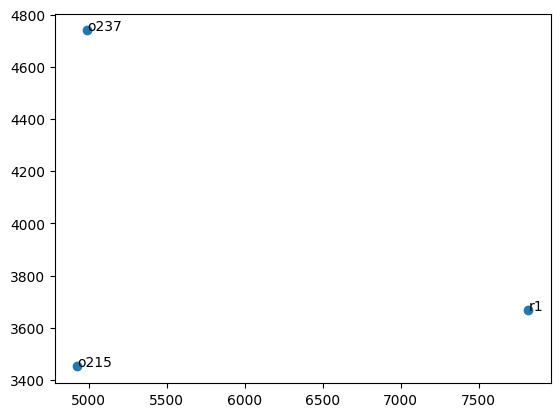

In [241]:
# Plot chart
import matplotlib.pyplot as plt
x = [locations.at['r1','x'],locations.at['o237','x'],locations.at['o215','x']]
y = [locations.at['r1','y'],locations.at['o237','y'],locations.at['o215','y']]
lable = ['r1','o237','o215']
for i, txt in enumerate(lable):
    plt.annotate(txt, (x[i], y[i]))
plt.scatter(x, y)
plt.show()